In [7]:
# Upload the zip file
from google.colab import files
uploaded = files.upload()

# Unzip the uploaded file
import zipfile
import os

for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('/content')

# Change directory to the unzipped folder (replace 'YourFolderName' with the actual folder name)
os.chdir('/content/arc')

# Load the JSON files
import json

# Load the training challenges and solutions
with open('arc-agi_training_challenges.json', 'r') as file:
    training_challenges = json.load(file)

with open('arc-agi_training_solutions.json', 'r') as file:
    training_solutions = json.load(file)

# Load the evaluation challenges and solutions
with open('arc-agi_evaluation_challenges.json', 'r') as file:
    evaluation_challenges = json.load(file)

with open('arc-agi_evaluation_solutions.json', 'r') as file:
    evaluation_solutions = json.load(file)


Saving arc.zip to arc.zip


Epoch 1/10, Loss: 1.0602368924021721
Epoch 2/10, Loss: 0.9798259519040584
Epoch 3/10, Loss: 0.9549309121072292
Epoch 4/10, Loss: 0.9225073955953121
Epoch 5/10, Loss: 0.8810015040636062
Epoch 6/10, Loss: 0.843041266053915
Epoch 7/10, Loss: 0.8179843102395534
Epoch 8/10, Loss: 0.801436303332448
Epoch 9/10, Loss: 0.790281028971076
Epoch 10/10, Loss: 0.7803393791615963


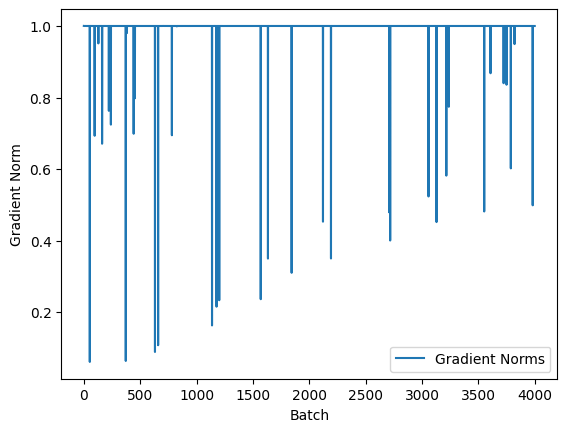

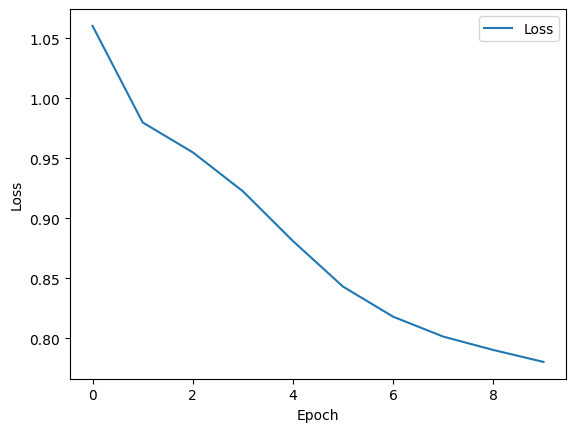

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import json
import os

def pad_grid(grid, target_size=(30, 30)):
    if grid.ndim != 2:
        raise ValueError(f"Grid should have 2 dimensions, but has {grid.ndim}")
    padded_grid = np.zeros(target_size, dtype=int)
    padded_grid[:grid.shape[0], :grid.shape[1]] = grid
    mean = np.mean(padded_grid)
    std = np.std(padded_grid)
    if std == 0:
        std = 1  # Prevent division by zero
    padded_grid = (padded_grid - mean) / std
    return padded_grid

class ARCDataset(Dataset):
    def __init__(self, challenges, solutions):
        self.challenges = challenges
        self.solutions = solutions
        self.keys = list(challenges.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        challenge = self.challenges[key]
        solution = self.solutions[key]
        train_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['train']]
        train_outputs = [pad_grid(np.array(pair['output'])) for pair in challenge['train']]
        test_inputs = [pad_grid(np.array(pair['input'])) for pair in challenge['test']]
        test_outputs = [pad_grid(np.array(output)) for output in solution]
        train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
        train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
        test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
        test_outputs = torch.tensor(test_outputs, dtype=torch.float32)
        train_inputs = train_inputs.unsqueeze(1)
        train_outputs = train_outputs.unsqueeze(1)
        test_inputs = test_inputs.unsqueeze(1)
        test_outputs = test_outputs.unsqueeze(1)
        return train_inputs, train_outputs, test_inputs, test_outputs

with open('arc-agi_training_challenges.json') as f:
    training_challenges = json.load(f)
with open('arc-agi_training_solutions.json') as f:
    training_solutions = json.load(f)
with open('arc-agi_evaluation_challenges.json') as f:
    evaluation_challenges = json.load(f)
with open('arc-agi_evaluation_solutions.json') as f:
    evaluation_solutions = json.load(f)
with open('arc-agi_test_challenges.json') as f:
    test_challenges = json.load(f)

train_dataset = ARCDataset(training_challenges, training_solutions)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

class ARCNN(nn.Module):
    def __init__(self):
        super(ARCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 30 * 30, 512)
        self.fc2 = nn.Linear(512, 30 * 30)
        self.apply(weights_init)

    def forward(self, x):
        batch_size, num_pairs, _, height, width = x.size()
        x = x.view(batch_size * num_pairs, 1, height, width)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, num_pairs, 1, height, width)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model = ARCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Further reduced learning rate

def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth.tar'):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)

grad_norms = []
losses = []

num_epochs = 10
grad_clip_value = 1.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for train_inputs, train_outputs, _, _ in train_loader:
        # Data checks
        if torch.isnan(train_inputs).any() or torch.isnan(train_outputs).any():
            print("Found nan in input data")
            continue
        if torch.isinf(train_inputs).any() or torch.isinf(train_outputs).any():
            print("Found inf in input data")
            continue

        optimizer.zero_grad()
        outputs = model(train_inputs)

        # Check for nan or inf in outputs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Found nan or inf in model outputs")
            continue

        target_size = outputs.size()
        train_outputs = train_outputs.view(target_size)
        loss = criterion(outputs, train_outputs)

        # Check if loss is nan
        if torch.isnan(loss):
            print("Loss is nan, skipping this batch")
            continue

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

        # Log gradient norms
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                if torch.isnan(p.grad).any() or torch.isinf(p.grad).any():
                    print(f"Found nan or inf in gradients of {p.name}")
                    continue
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        grad_norms.append(total_norm)

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

    save_checkpoint(epoch + 1, model, optimizer, epoch_loss)

# Plotting gradient norms
plt.figure()
plt.plot(grad_norms, label='Gradient Norms')
plt.xlabel('Batch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

# Plotting loss
plt.figure()
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Save the trained model
torch.save(model.state_dict(), 'arc_model.pth')

# Optionally, save the entire model
torch.save(model, 'arc_model_full.pth')

# Evaluate the model
model.eval()  # Set the model to evaluation mode

def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for inputs, targets, _, _ in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss

# Assuming you have a validation or test DataLoader
val_dataset = ARCDataset(evaluation_challenges, evaluation_solutions)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

val_loss = evaluate_model(model, val_loader)
print(f'Validation Loss: {val_loss}')


Validation Loss: 0.8728036702424288


Test Loss: 0.8728036702424288


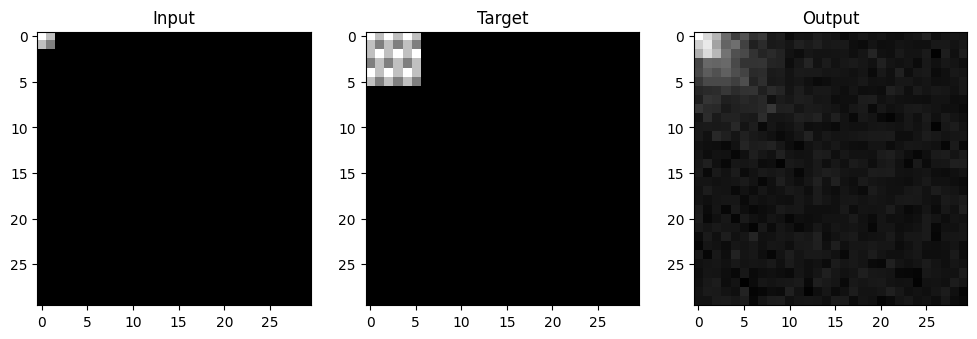

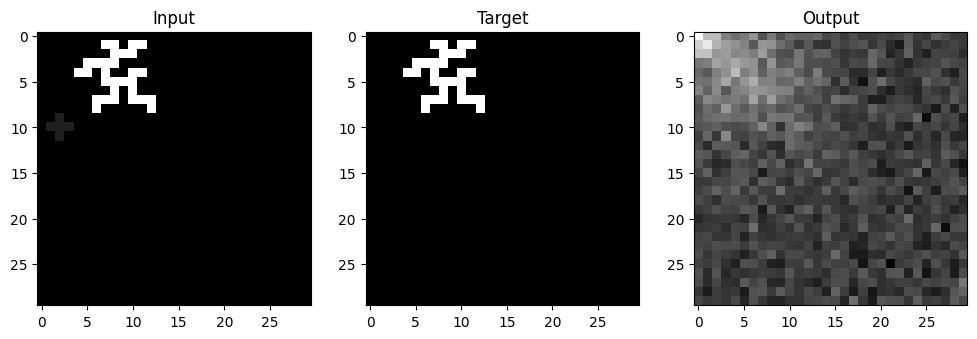

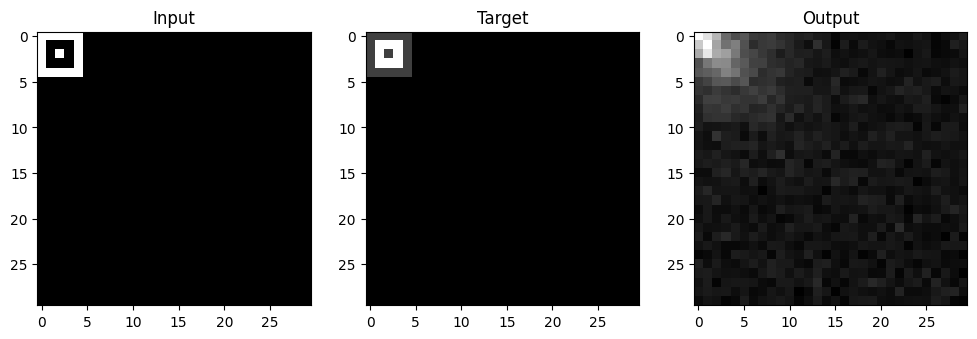

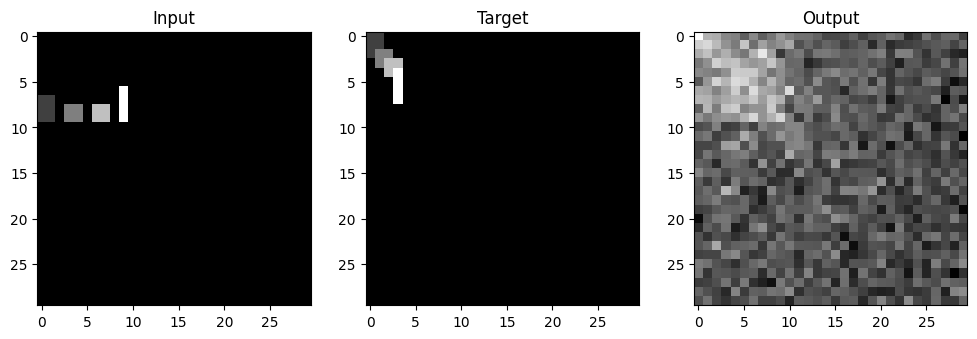

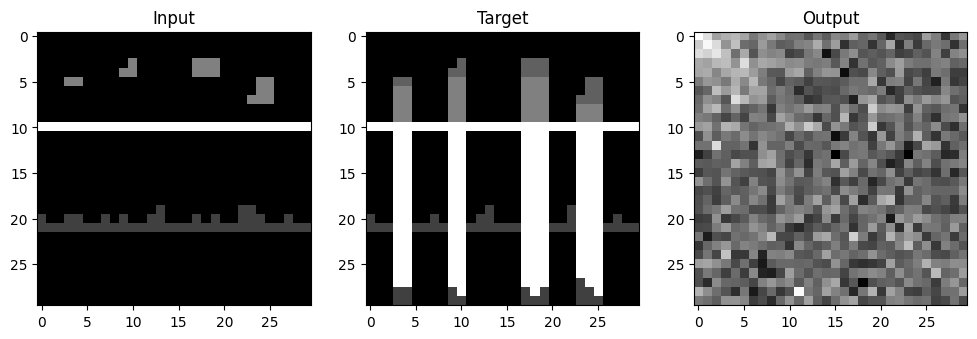

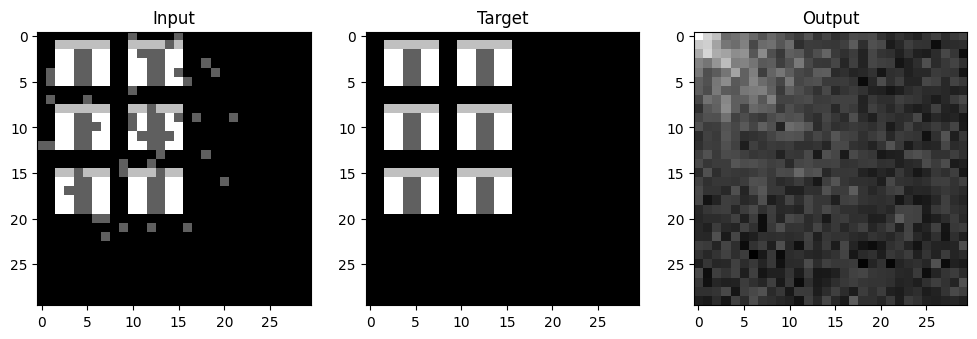

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming 'ARCModel' is your model class and 'ARCDataset' is your dataset class

# Load the trained model
model = ARCNN()
model.load_state_dict(torch.load('arc_model.pth'))
model.eval()

# Define your test dataset# Load the evaluation challenges and solutions
with open('arc-agi_evaluation_challenges.json', 'r') as file:
    test_challenges = json.load(file)

with open('arc-agi_evaluation_solutions.json', 'r') as file:
    test_solutions = json.load(file)
# Replace with your test solutions

test_dataset = ARCDataset(test_challenges, test_solutions)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()  # or another appropriate loss function

    with torch.no_grad():
        for inputs, targets, _, _ in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss

# Evaluate the model on the test set
test_loss = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss}')

# Visualization function
def visualize_results(model, dataloader):
    model.eval()
    for i, (inputs, targets, _, _) in enumerate(dataloader):
        outputs = model(inputs)

        # Squeeze the unnecessary dimensions and convert tensors to numpy arrays
        inputs_np = inputs.squeeze().cpu().numpy()
        targets_np = targets.squeeze().cpu().numpy()
        outputs_np = outputs.squeeze().cpu().detach().numpy()

        # Plot the input, target, and output
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Input')
        if inputs_np.ndim == 3:
            inputs_np = inputs_np[0]
        plt.imshow(inputs_np, cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Target')
        if targets_np.ndim == 3:
            targets_np = targets_np[0]
        plt.imshow(targets_np, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Output')
        if outputs_np.ndim == 3:
            outputs_np = outputs_np[0]
        plt.imshow(outputs_np, cmap='gray')

        plt.show()

        # Visualize a few examples
        if i >= 5:
            break

# Visualize results on the test set
visualize_results(model, test_loader)

